# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Import 

In [62]:
# system
import os 
import multiprocessing 
from joblib import (
    parallel_backend,
    Parallel,
    delayed
)
# warnings
import warnings

# Data manipulation and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing and ML
import spacy
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Settings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

# Random seed for reproducibility
RANDOM_STATE = 27

# Set environment variables for optimization
os.environ['OPENBLAS_NUM_THREADS'] = str(multiprocessing.cpu_count())
os.environ['MKL_NUM_THREADS'] = str(multiprocessing.cpu_count())
os.environ['VECLIB_MAXIMUM_THREADS'] = str(multiprocessing.cpu_count())
os.environ['NUMEXPR_NUM_THREADS'] = str(multiprocessing.cpu_count())

# Building the Machine Learning Pipeline with Performance Optimization
print(f"Number of CPU cores available: {multiprocessing.cpu_count()}")

Number of CPU cores available: 8


## Load Data

In [3]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [4]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [5]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Your Work

## Set cols Variable

In [150]:
cols_feature_num = ['Age', 'Positive Feedback Count']
cols_feature_cat = ['Division Name', 'Department Name', 'Class Name'] 
cols_feature_text = ['Title', 'Review Text']
cols_feature = cols_feature_num + cols_feature_cat + cols_feature_text

col_target = 'Recommended IND'


## Data Exploration

#### Target analysis

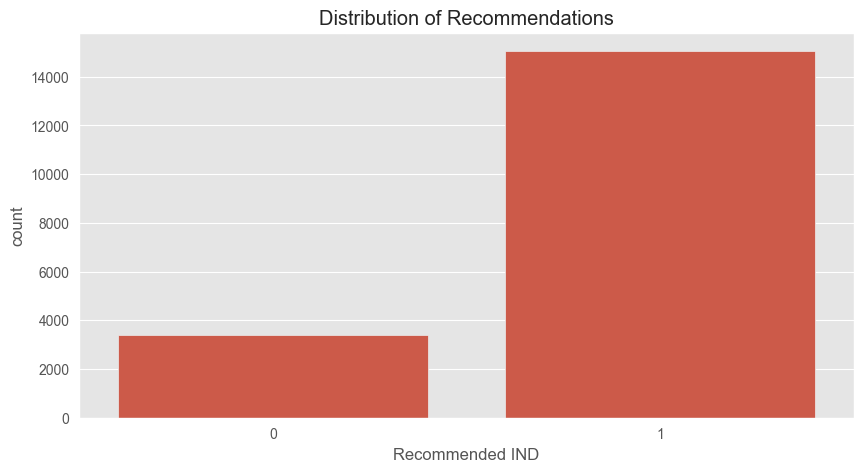


Recommendation Distribution:
Recommended IND
1    0.816235
0    0.183765
Name: proportion, dtype: float64


In [7]:
# Plot target distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x=col_target)
plt.title('Distribution of Recommendations')
plt.show()

# Print distribution percentages
rec_dist = df[col_target].value_counts(normalize=True)
print("\nRecommendation Distribution:")
print(rec_dist)

### Numerical Features Analysis

##### Distribution

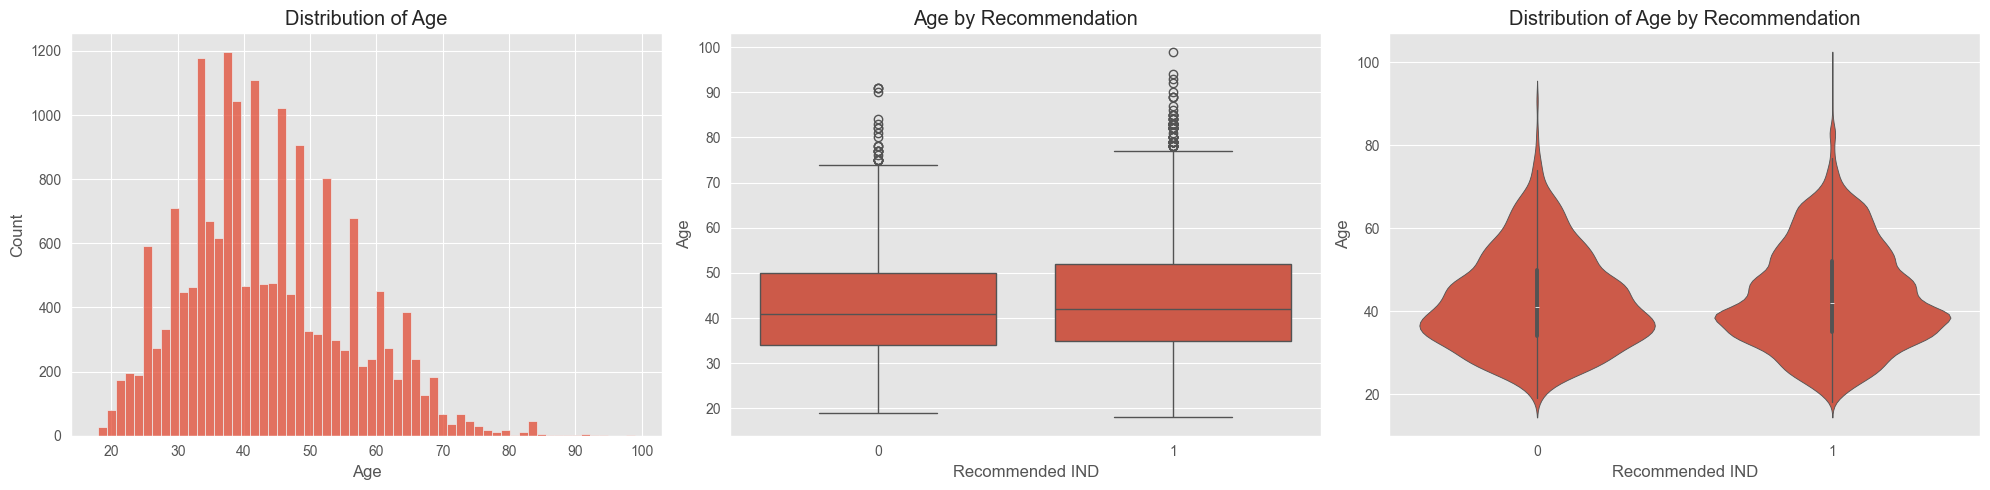


Age Summary Statistics by Recommendation:
                   count       mean        std   min   25%   50%   75%   max
Recommended IND                                                             
0                 3389.0  42.437592  11.694862  19.0  34.0  41.0  50.0  91.0
1                15053.0  43.596625  12.357405  18.0  35.0  42.0  52.0  99.0


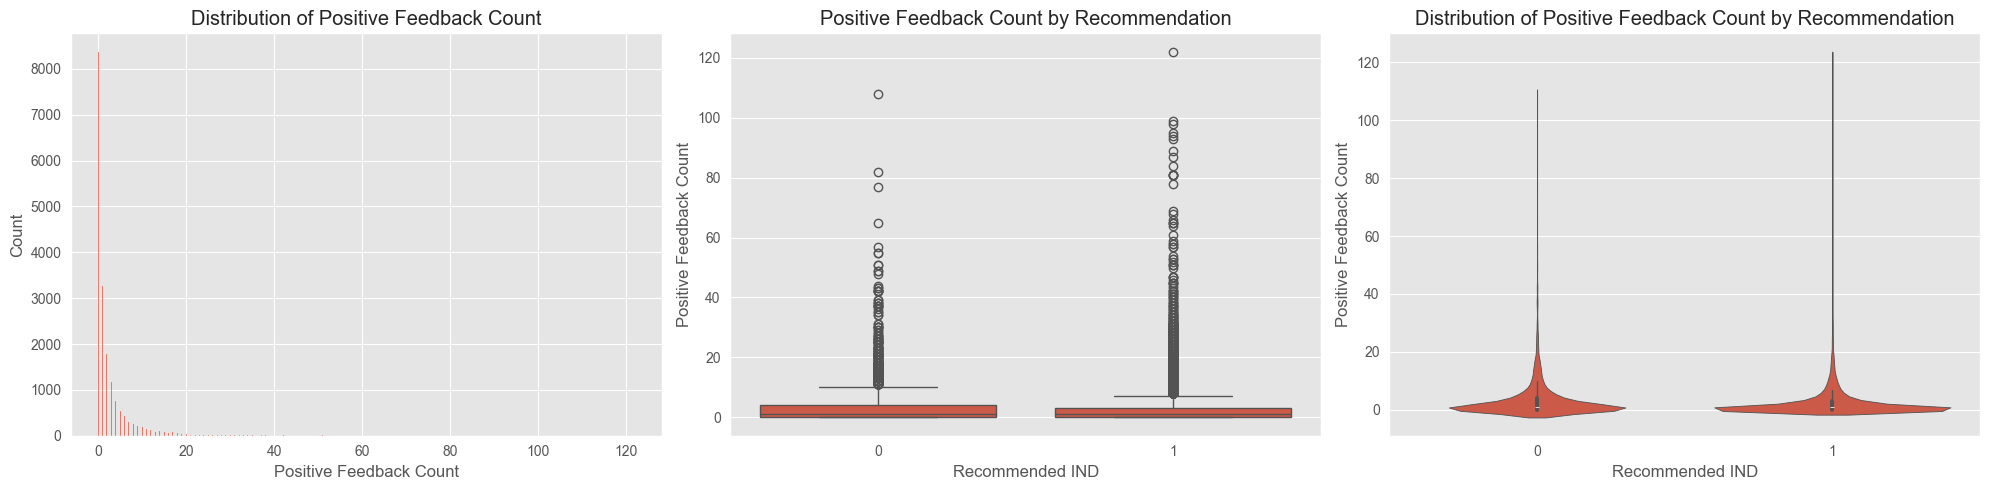


Positive Feedback Count Summary Statistics by Recommendation:
                   count      mean       std  min  25%  50%  75%    max
Recommended IND                                                        
0                 3389.0  3.428740  6.698298  0.0  0.0  1.0  4.0  108.0
1                15053.0  2.532851  5.745748  0.0  0.0  1.0  3.0  122.0


In [8]:
# Create plots for each numerical feature
for col in cols_feature_num:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Distribution plot
    sns.histplot(data=df, x=col, ax=ax1)
    ax1.set_title(f'Distribution of {col}')
    
    # Box plot by recommendation
    sns.boxplot(data=df, x=col_target, y=col, ax=ax2)
    ax2.set_title(f'{col} by Recommendation')
    
    # Violin plot to show distribution density
    sns.violinplot(data=df, x=col_target, y=col, ax=ax3)
    ax3.set_title(f'Distribution of {col} by Recommendation')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics by recommendation
    print(f"\n{col} Summary Statistics by Recommendation:")
    print(df.groupby(col_target)[col].describe())

#### Correlation 

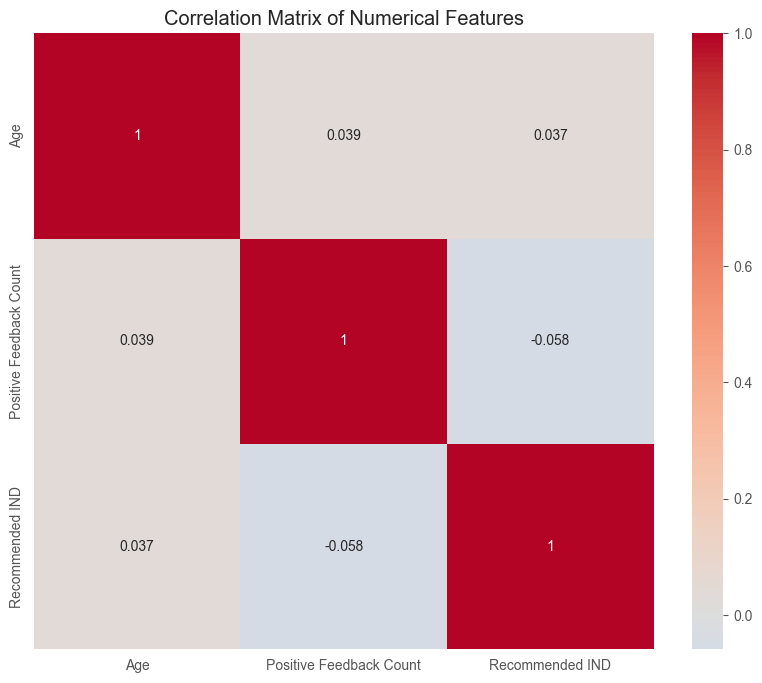

In [10]:
# Create correlation matrix for numerical features
numerical_data = df[cols_feature_num + [col_target]]
correlation_matrix = numerical_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Categorical Features Analysis

#### Distribution

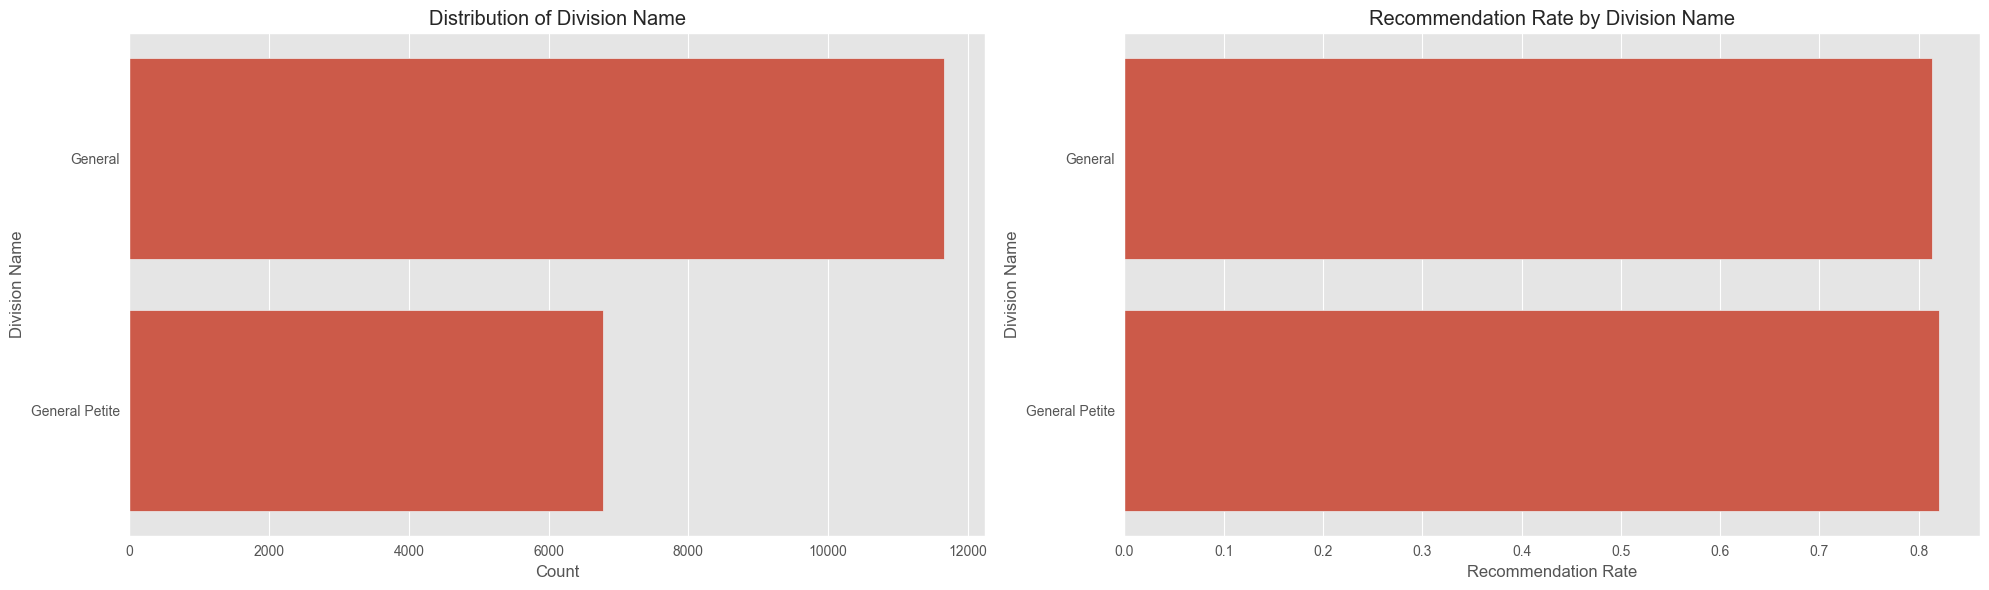


Division Name Value Counts:
Division Name
General           11664
General Petite     6778
Name: count, dtype: int64

Division Name Recommendation Rates:
Division Name
General           0.813615
General Petite    0.820744
Name: Recommended IND, dtype: float64


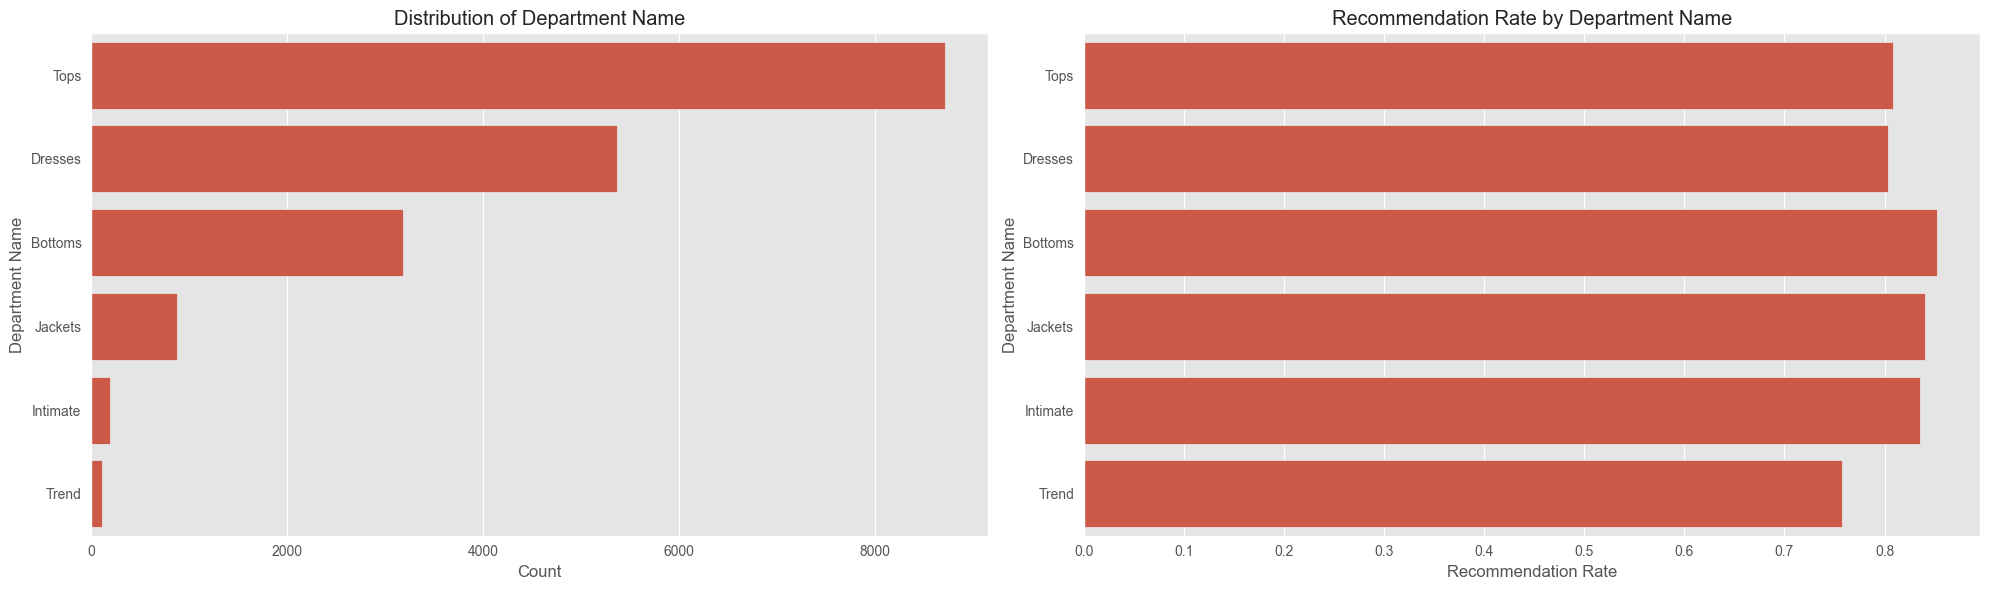


Department Name Value Counts:
Department Name
Tops        8713
Dresses     5371
Bottoms     3184
Jackets      879
Intimate     188
Trend        107
Name: count, dtype: int64

Department Name Recommendation Rates:
Department Name
Tops        0.808791
Dresses     0.803202
Bottoms     0.852701
Jackets     0.840728
Intimate    0.835106
Trend       0.757009
Name: Recommended IND, dtype: float64


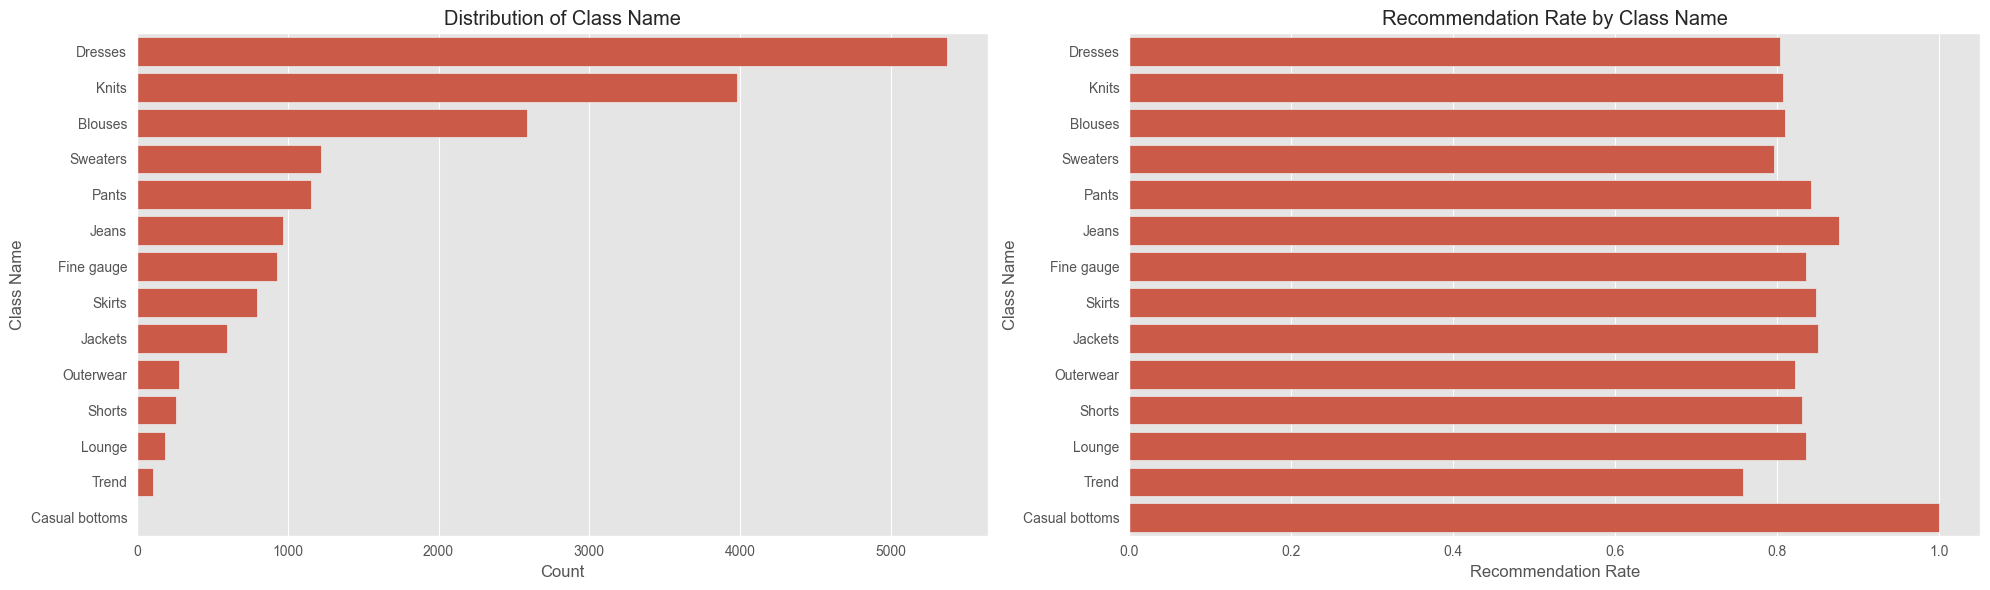


Class Name Value Counts:
Class Name
Dresses           5371
Knits             3981
Blouses           2587
Sweaters          1218
Pants             1157
Jeans              970
Fine gauge         927
Skirts             796
Jackets            598
Outerwear          281
Shorts             260
Lounge             188
Trend              107
Casual bottoms       1
Name: count, dtype: int64

Class Name Recommendation Rates:
Class Name
Dresses           0.803202
Knits             0.806330
Blouses           0.809432
Sweaters          0.795567
Pants             0.840968
Jeans             0.876289
Fine gauge        0.834951
Skirts            0.847990
Jackets           0.849498
Outerwear         0.822064
Shorts            0.830769
Lounge            0.835106
Trend             0.757009
Casual bottoms    1.000000
Name: Recommended IND, dtype: float64


In [9]:
for col in cols_feature_cat:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Get value counts and recommendation rates
    value_counts = df[col].value_counts()
    rec_rate = df.groupby(col)['Recommended IND'].mean()
    
    # Sort both by value counts (most frequent first)
    sorted_index = value_counts.index
    value_counts = value_counts[sorted_index]
    rec_rate = rec_rate[sorted_index]
    
    # Distribution of categories
    sns.barplot(x=value_counts.values, y=sorted_index, ax=ax1)
    ax1.set_title(f'Distribution of {col}')
    ax1.set_xlabel('Count')
    
    # Recommendation rate by category
    sns.barplot(x=rec_rate.values, y=sorted_index, ax=ax2)
    ax2.set_title(f'Recommendation Rate by {col}')
    ax2.set_xlabel('Recommendation Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Print value counts and recommendation rates
    print(f"\n{col} Value Counts:")
    print(value_counts)
    print(f"\n{col} Recommendation Rates:")
    print(rec_rate)

#### Chi-square

In [11]:
# Calculate chi-square test of independence for categorical features
from scipy.stats import chi2_contingency

print("\nChi-square test results for categorical features:")
for col in cols_feature_cat:
    contingency_table = pd.crosstab(df[col], df[col_target])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\n{col}:")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.10f}")


Chi-square test results for categorical features:

Division Name:
Chi-square statistic: 1.41
p-value: 0.2358232999

Department Name:
Chi-square statistic: 43.99
p-value: 0.0000000232

Class Name:
Chi-square statistic: 56.52
p-value: 0.0000002178


### Text analysis

#### Text length 

Text Length Statistics:


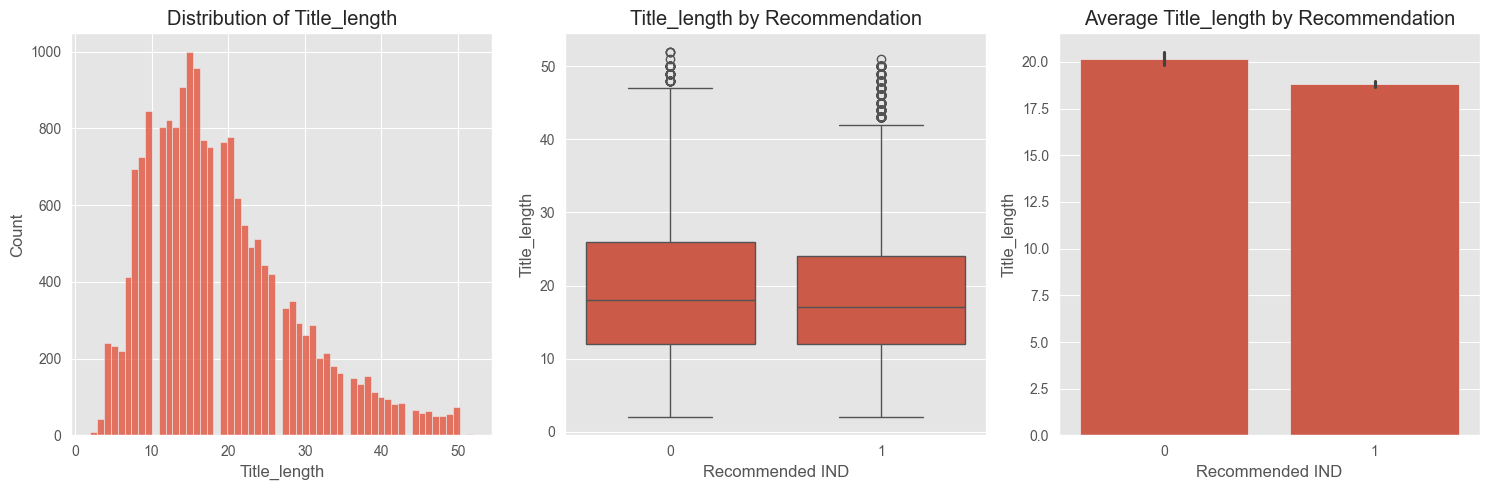


Title_length Summary Statistics:
count    18442.000000
mean        19.067672
std          9.569247
min          2.000000
25%         12.000000
50%         17.000000
75%         24.000000
max         52.000000
Name: Title_length, dtype: float64

Mean length by recommendation:
Recommended IND
0    20.167011
1    18.820169
Name: Title_length, dtype: float64


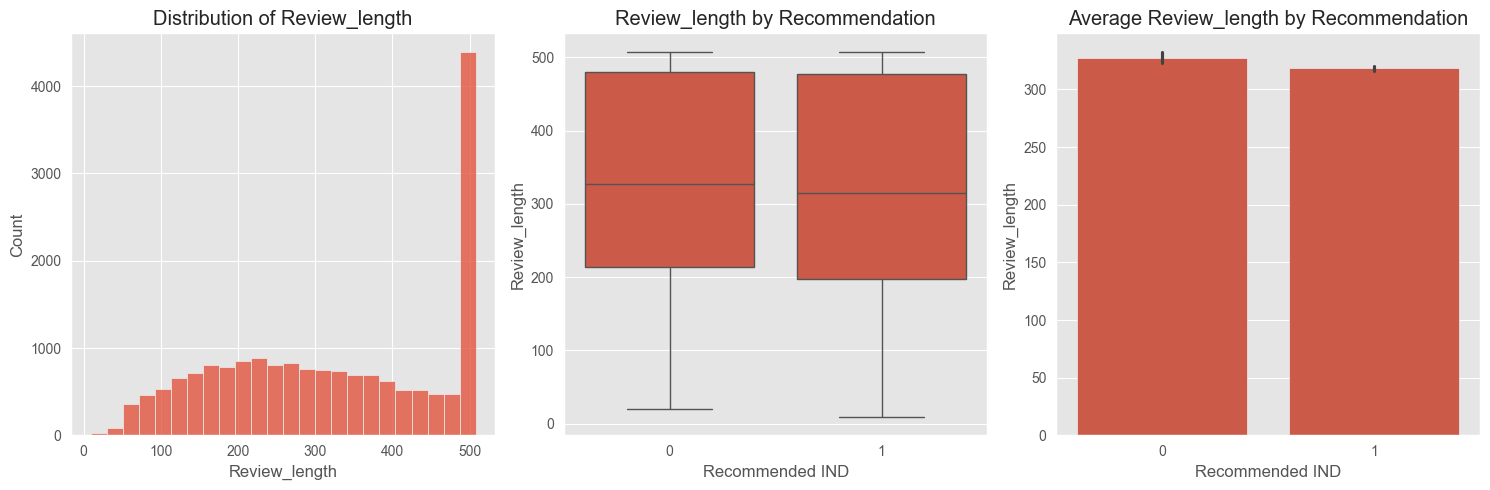


Review_length Summary Statistics:
count    18442.000000
mean       319.989535
std        141.953692
min          9.000000
25%        201.000000
50%        317.500000
75%        478.000000
max        508.000000
Name: Review_length, dtype: float64

Mean length by recommendation:
Recommended IND
0    327.539687
1    318.289710
Name: Review_length, dtype: float64


In [12]:
 print("Text Length Statistics:")
df['Title_length'] = df['Title'].str.len()
df['Review_length'] = df['Review Text'].str.len()

for col in ['Title_length', 'Review_length']:
    plt.figure(figsize=(15, 5))
    
    # Distribution plot
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    
    # Box plot by recommendation
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, x='Recommended IND', y=col)
    plt.title(f'{col} by Recommendation')
    
    # Average length by recommendation
    plt.subplot(1, 3, 3)
    sns.barplot(data=df, x='Recommended IND', y=col)
    plt.title(f'Average {col} by Recommendation')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{col} Summary Statistics:")
    print(df[col].describe())
    print("\nMean length by recommendation:")
    print(df.groupby('Recommended IND')[col].mean())


#### Text preprocessing

Preprocessing text data with spaCy...

Named Entity Analysis for not recommended reviews:


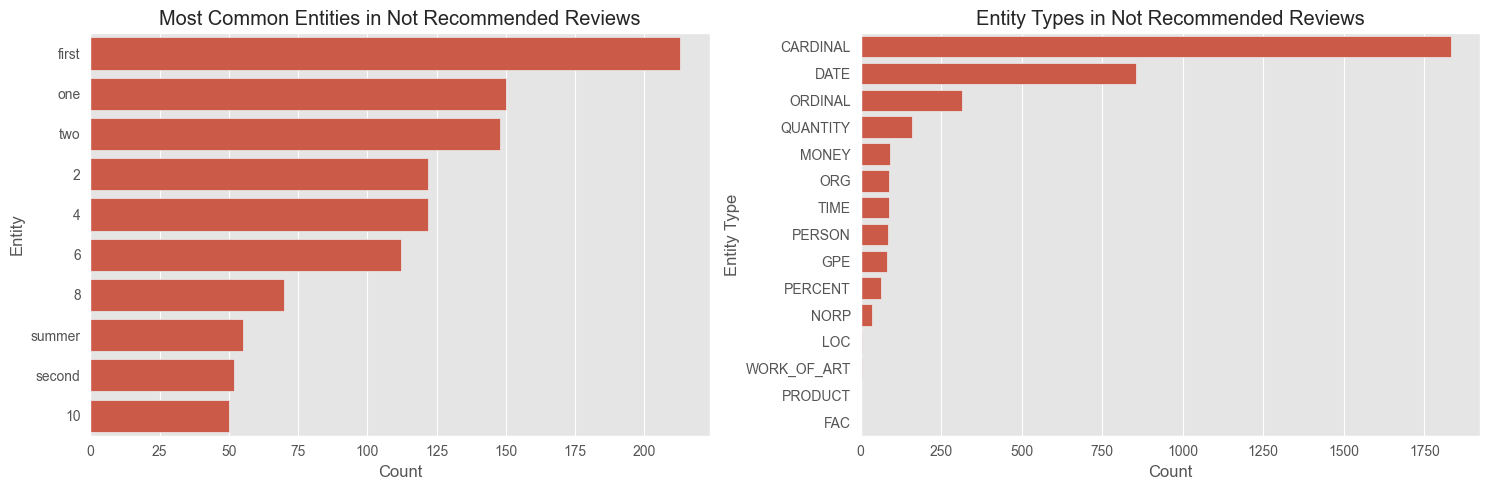


Most common entities:
   Entity  Count
0   first    213
1     one    150
2     two    148
3       2    122
4       4    122
5       6    112
6       8     70
7  summer     55
8  second     52
9      10     50

Entity types distribution:
    Entity Type  Count
0      CARDINAL   1831
1          DATE    855
2       ORDINAL    316
3      QUANTITY    161
4         MONEY     92
5           ORG     89
6          TIME     88
7        PERSON     85
8           GPE     81
9       PERCENT     65
10         NORP     35
11          LOC      5
12  WORK_OF_ART      3
13      PRODUCT      2
14          FAC      1

Named Entity Analysis for recommended reviews:


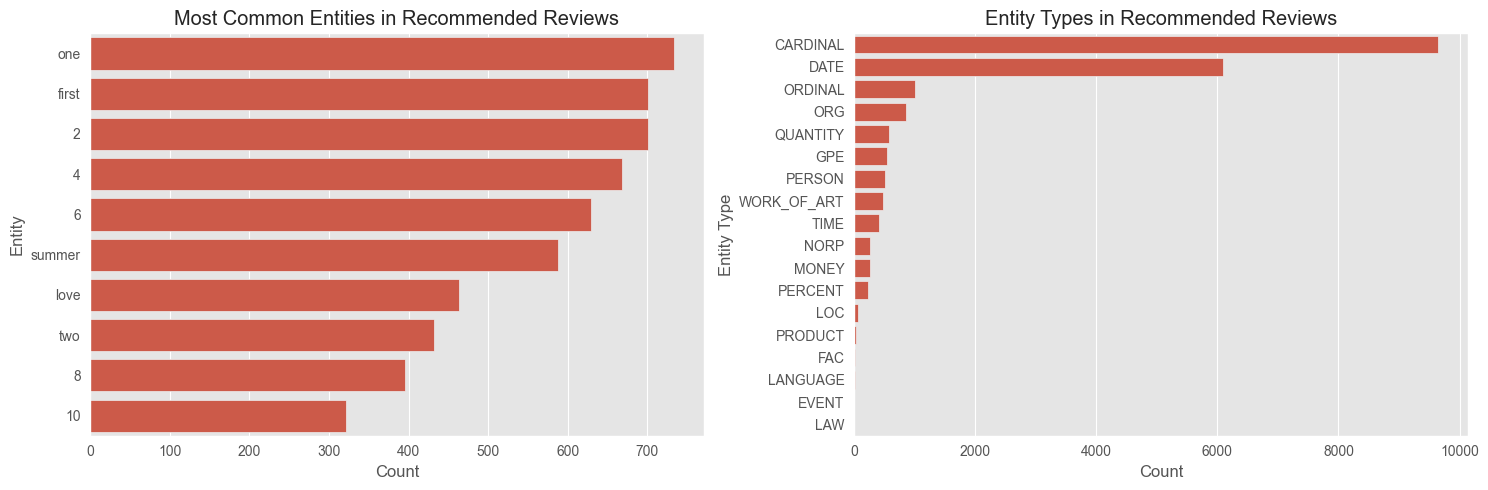


Most common entities:
   Entity  Count
0     one    734
1   first    701
2       2    701
3       4    668
4       6    629
5  summer    588
6    love    463
7     two    432
8       8    395
9      10    321

Entity types distribution:
    Entity Type  Count
0      CARDINAL   9650
1          DATE   6090
2       ORDINAL   1008
3           ORG    853
4      QUANTITY    581
5           GPE    541
6        PERSON    507
7   WORK_OF_ART    474
8          TIME    407
9          NORP    263
10        MONEY    262
11      PERCENT    219
12          LOC     56
13      PRODUCT     33
14          FAC      9
15     LANGUAGE      5
16        EVENT      3
17          LAW      2

Part-of-Speech Analysis for not recommended reviews:


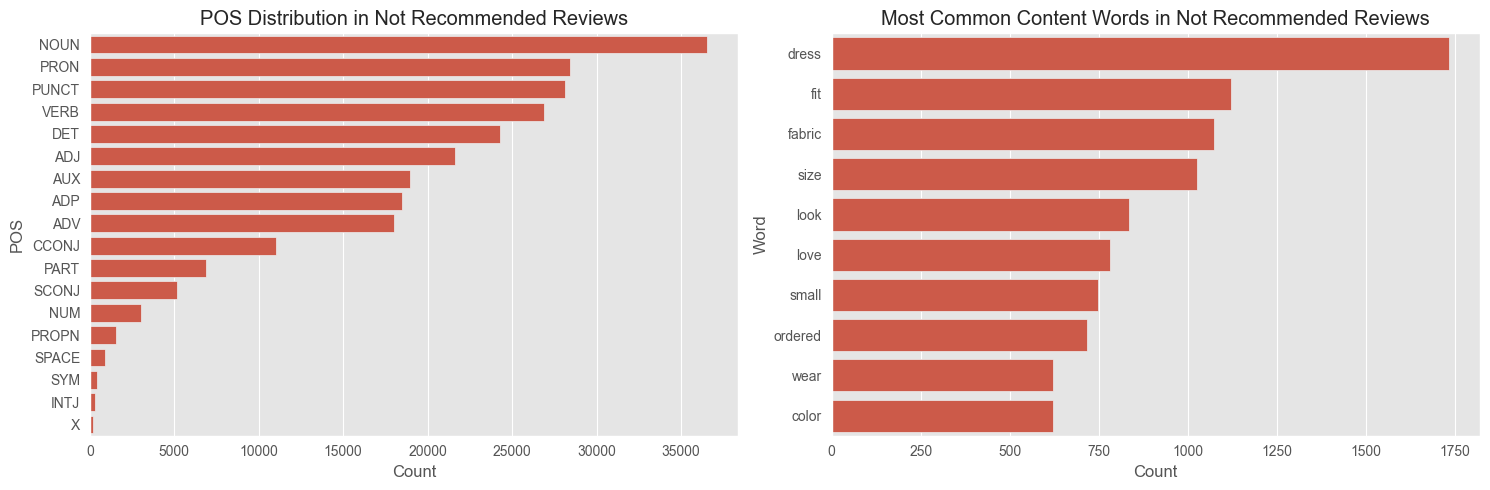


POS distribution:
      POS  Count
0    NOUN  36568
1    PRON  28416
2   PUNCT  28115
3    VERB  26897
4     DET  24280
5     ADJ  21622
6     AUX  18936
7     ADP  18500
8     ADV  17991
9   CCONJ  11000
10   PART   6873
11  SCONJ   5158
12    NUM   3015
13  PROPN   1558
14  SPACE    884
15    SYM    440
16   INTJ    280
17      X    168

Most common content words:
      Word  Count
0    dress   1733
1      fit   1121
2   fabric   1073
3     size   1025
4     look    835
5     love    781
6    small    747
7  ordered    717
8     wear    622
9    color    622

Part-of-Speech Analysis for recommended reviews:


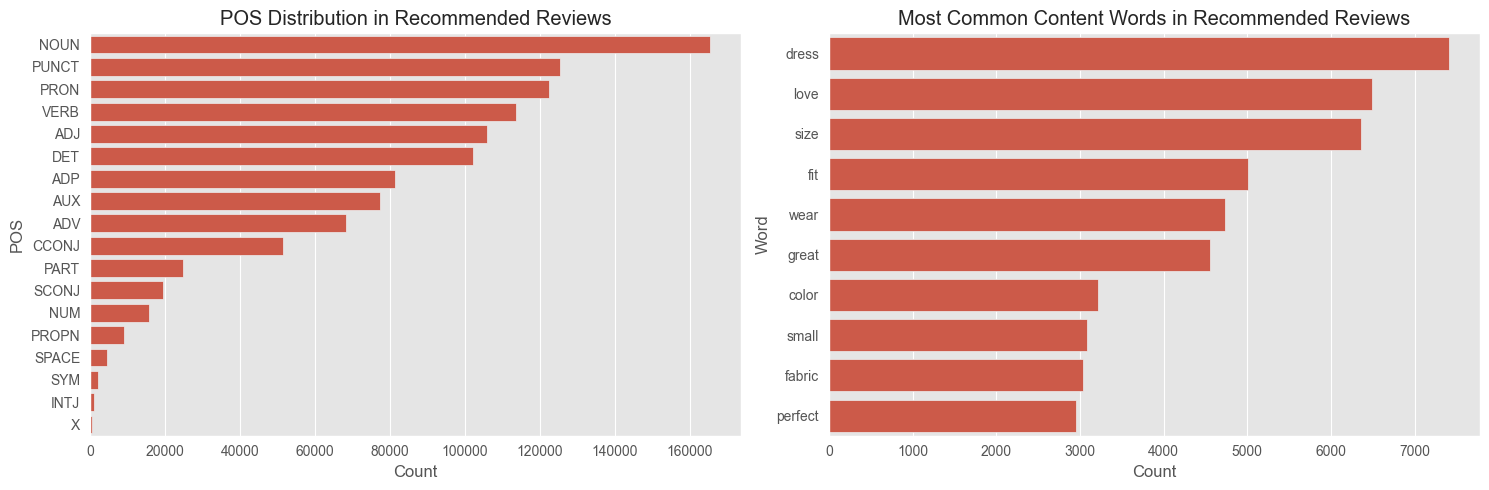


POS distribution:
      POS   Count
0    NOUN  165326
1   PUNCT  125405
2    PRON  122335
3    VERB  113522
4     ADJ  105940
5     DET  102006
6     ADP   81217
7     AUX   77344
8     ADV   68222
9   CCONJ   51395
10   PART   24704
11  SCONJ   19418
12    NUM   15686
13  PROPN    9026
14  SPACE    4686
15    SYM    2250
16   INTJ     996
17      X     601

Most common content words:
      Word  Count
0    dress   7411
1     love   6492
2     size   6361
3      fit   5010
4     wear   4737
5    great   4553
6    color   3217
7    small   3089
8   fabric   3041
9  perfect   2958


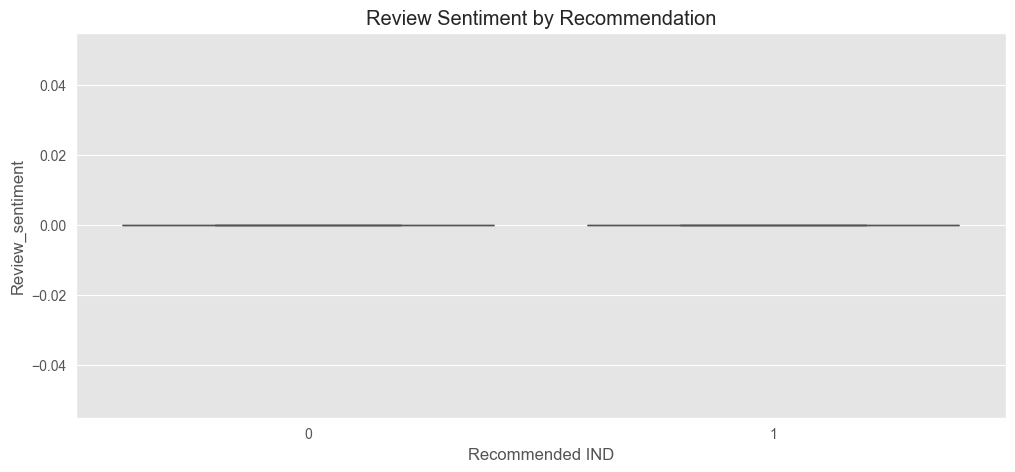


Sentiment Statistics by Recommendation:
                   count  mean  std  min  25%  50%  75%  max
Recommended IND                                             
0                 3389.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                15053.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [14]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def preprocess_with_spacy(text):
    """Preprocess text using spaCy's pipeline."""
    if pd.isna(text):
        return ''
    
    # Process the text with spaCy
    doc = nlp(text)
    
    # Get lemmatized tokens, excluding stop words and punctuation
    tokens = [token.lemma_.lower() for token in doc 
             if not token.is_stop 
             and not token.is_punct 
             and token.lemma_.strip()]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text data with spaCy...")
df['Title_processed'] = df['Title'].apply(preprocess_with_spacy)
df['Review_processed'] = df['Review Text'].apply(preprocess_with_spacy)


 #### Named Entity Recognition Analysis


Named Entity Analysis for not recommended reviews:


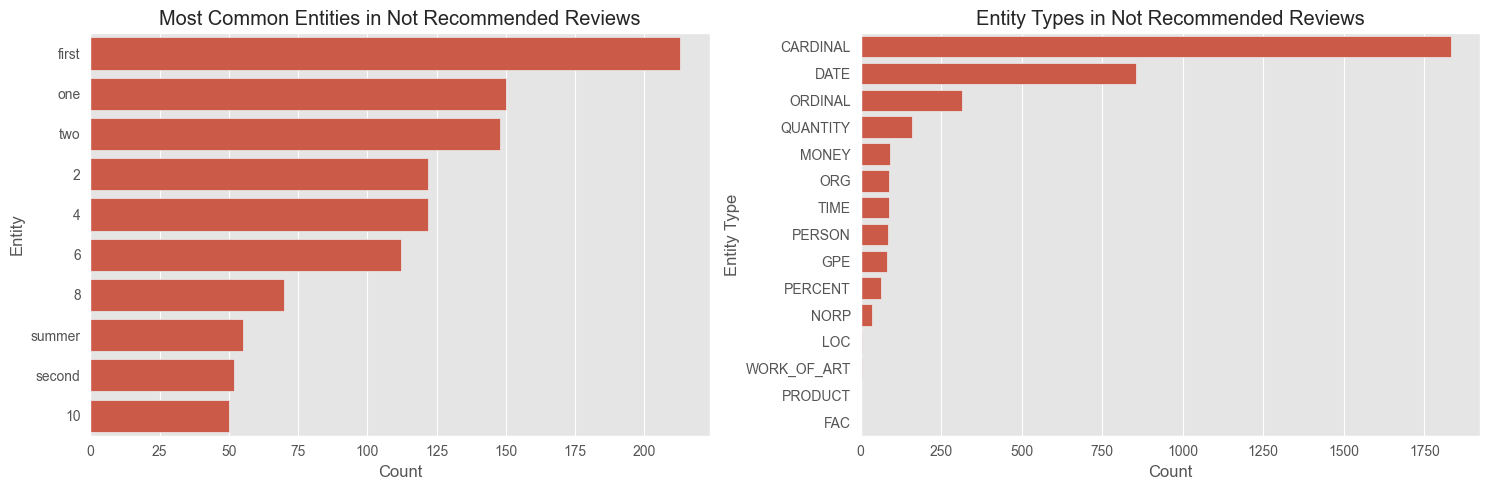


Most common entities:
   Entity  Count
0   first    213
1     one    150
2     two    148
3       2    122
4       4    122
5       6    112
6       8     70
7  summer     55
8  second     52
9      10     50

Entity types distribution:
    Entity Type  Count
0      CARDINAL   1831
1          DATE    855
2       ORDINAL    316
3      QUANTITY    161
4         MONEY     92
5           ORG     89
6          TIME     88
7        PERSON     85
8           GPE     81
9       PERCENT     65
10         NORP     35
11          LOC      5
12  WORK_OF_ART      3
13      PRODUCT      2
14          FAC      1

Named Entity Analysis for recommended reviews:


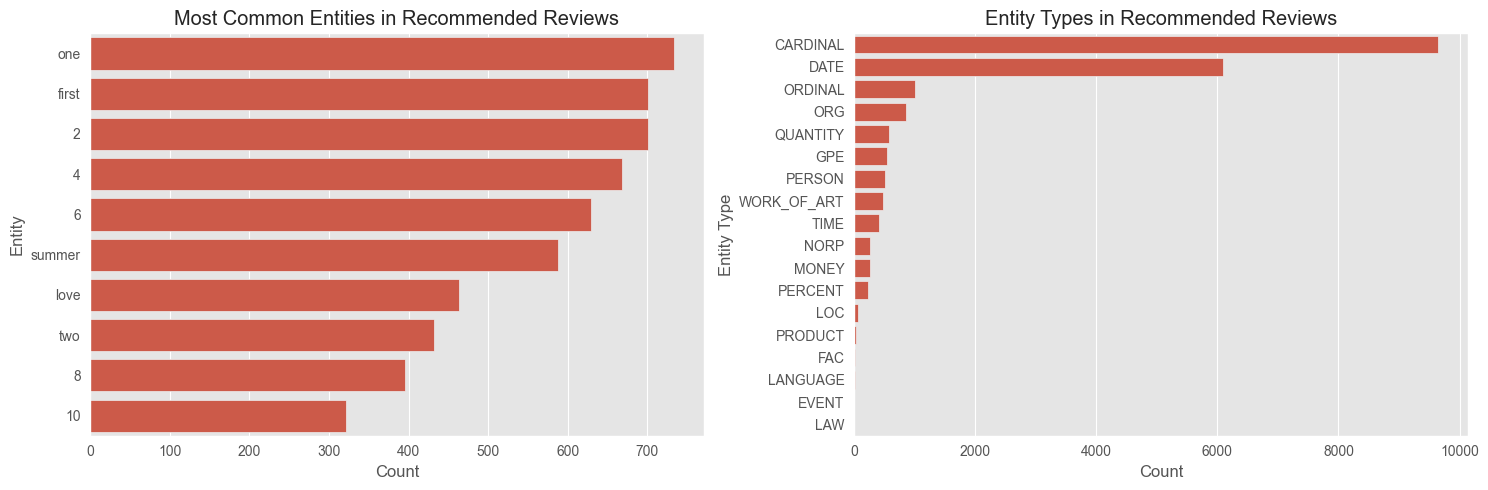


Most common entities:
   Entity  Count
0     one    734
1   first    701
2       2    701
3       4    668
4       6    629
5  summer    588
6    love    463
7     two    432
8       8    395
9      10    321

Entity types distribution:
    Entity Type  Count
0      CARDINAL   9650
1          DATE   6090
2       ORDINAL   1008
3           ORG    853
4      QUANTITY    581
5           GPE    541
6        PERSON    507
7   WORK_OF_ART    474
8          TIME    407
9          NORP    263
10        MONEY    262
11      PERCENT    219
12          LOC     56
13      PRODUCT     33
14          FAC      9
15     LANGUAGE      5
16        EVENT      3
17          LAW      2


In [17]:
def analyze_entities(texts, n=10):
    """Analyze named entities in a series of texts."""
    entity_counts = Counter()
    entity_types = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        doc = nlp(text)
        for ent in doc.ents:
            entity_counts[ent.text.lower()] += 1
            entity_types[ent.label_] += 1
    
    return (pd.DataFrame(entity_counts.most_common(n), columns=['Entity', 'Count']),
            pd.DataFrame(entity_types.most_common(), columns=['Entity Type', 'Count']))

# Analyze entities by recommendation
for rec in [0, 1]:
    print(f"\nNamed Entity Analysis for {'not ' if rec == 0 else ''}recommended reviews:")
    
    # Analyze reviews
    entities, entity_types = analyze_entities(df[df['Recommended IND'] == rec]['Review Text'])
    
    # Plot entities
    plt.figure(figsize=(15, 5))
    
    # Most common entities
    plt.subplot(1, 2, 1)
    sns.barplot(data=entities, x='Count', y='Entity')
    plt.title(f"Most Common Entities in {'Not ' if rec == 0 else ''}Recommended Reviews")
    
    # Entity types
    plt.subplot(1, 2, 2)
    sns.barplot(data=entity_types, x='Count', y='Entity Type')
    plt.title(f"Entity Types in {'Not ' if rec == 0 else ''}Recommended Reviews")
    
    plt.tight_layout()
    plt.show()
    
    print("\nMost common entities:")
    print(entities)
    print("\nEntity types distribution:")
    print(entity_types)

#### Part-of-Speech Analysis


Part-of-Speech Analysis for not recommended reviews:
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.0s
[CV] END classifier__max_depth=10, classifier__mi

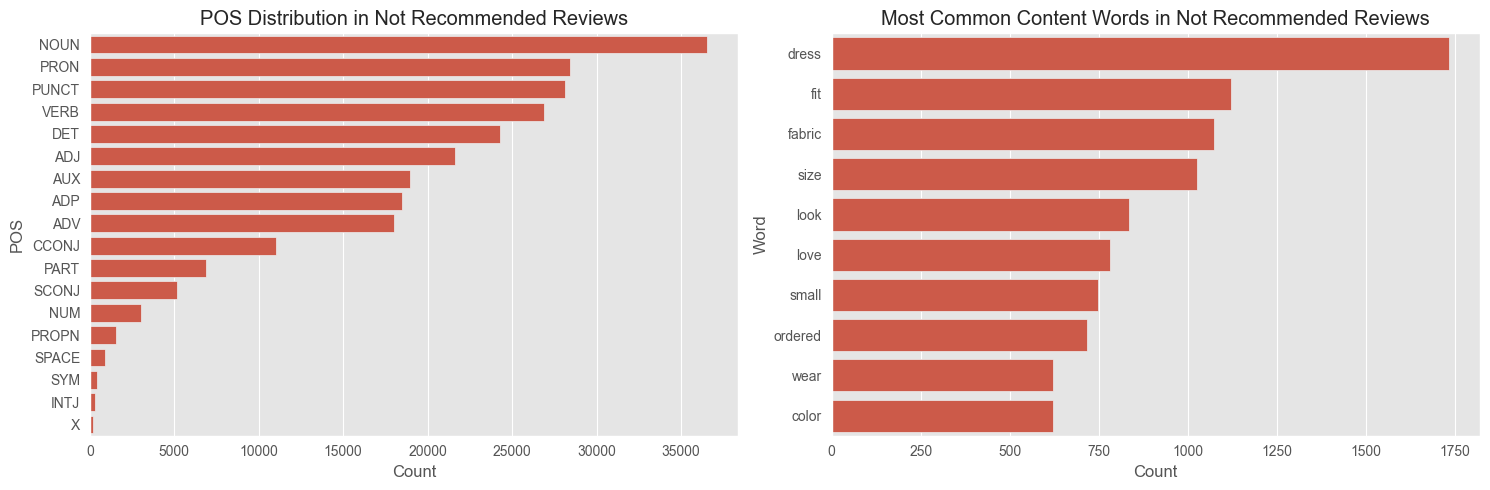


POS distribution:
      POS  Count
0    NOUN  36568
1    PRON  28416
2   PUNCT  28115
3    VERB  26897
4     DET  24280
5     ADJ  21622
6     AUX  18936
7     ADP  18500
8     ADV  17991
9   CCONJ  11000
10   PART   6873
11  SCONJ   5158
12    NUM   3015
13  PROPN   1558
14  SPACE    884
15    SYM    440
16   INTJ    280
17      X    168

Most common content words:
      Word  Count
0    dress   1733
1      fit   1121
2   fabric   1073
3     size   1025
4     look    835
5     love    781
6    small    747
7  ordered    717
8     wear    622
9    color    622

Part-of-Speech Analysis for recommended reviews:


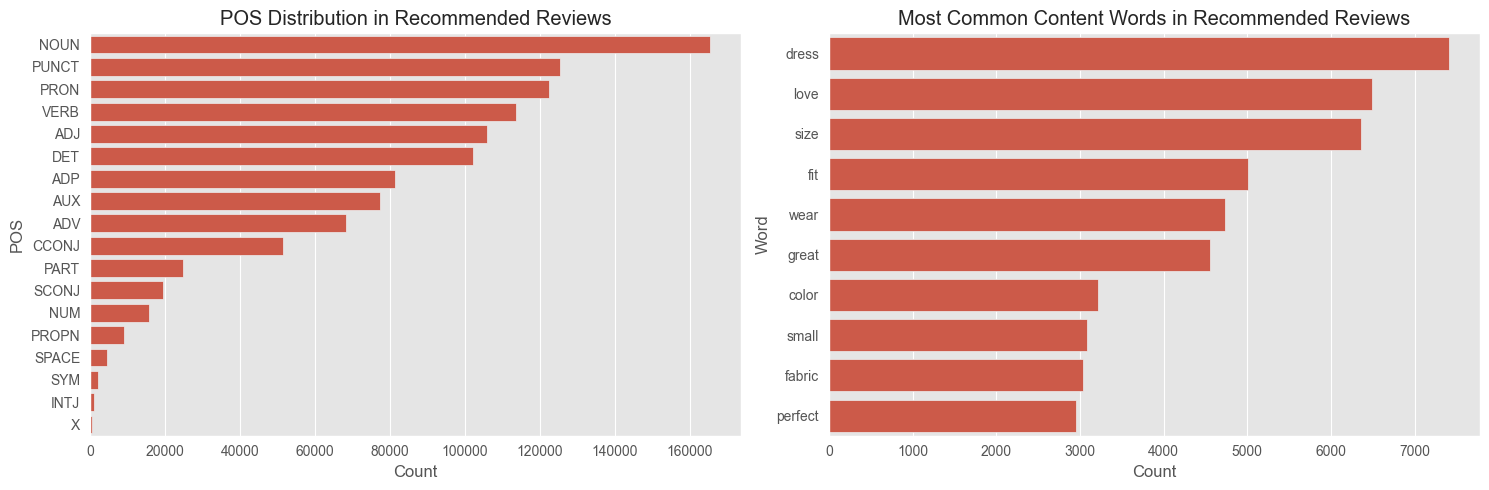


POS distribution:
      POS   Count
0    NOUN  165326
1   PUNCT  125405
2    PRON  122335
3    VERB  113522
4     ADJ  105940
5     DET  102006
6     ADP   81217
7     AUX   77344
8     ADV   68222
9   CCONJ   51395
10   PART   24704
11  SCONJ   19418
12    NUM   15686
13  PROPN    9026
14  SPACE    4686
15    SYM    2250
16   INTJ     996
17      X     601

Most common content words:
      Word  Count
0    dress   7411
1     love   6492
2     size   6361
3      fit   5010
4     wear   4737
5    great   4553
6    color   3217
7    small   3089
8   fabric   3041
9  perfect   2958


In [31]:
def analyze_pos(texts, n=10):
    """Analyze parts of speech in a series of texts."""
    pos_counts = Counter()
    important_words = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        doc = nlp(text)
        for token in doc:
            pos_counts[token.pos_] += 1
            # Only count content words (nouns, verbs, adjectives, adverbs)
            if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and not token.is_stop:
                important_words[token.text.lower()] += 1
    
    return (pd.DataFrame(pos_counts.most_common(), columns=['POS', 'Count']),
            pd.DataFrame(important_words.most_common(n), columns=['Word', 'Count']))

# Analyze POS by recommendation
for rec in [0, 1]:
    print(f"\nPart-of-Speech Analysis for {'not ' if rec == 0 else ''}recommended reviews:")
    
    pos_counts, important_words = analyze_pos(df[df['Recommended IND'] == rec]['Review Text'])
    
    plt.figure(figsize=(15, 5))
    
    # POS distribution
    plt.subplot(1, 2, 1)
    sns.barplot(data=pos_counts, x='Count', y='POS')
    plt.title(f"POS Distribution in {'Not ' if rec == 0 else ''}Recommended Reviews")
    
    # Important words
    plt.subplot(1, 2, 2)
    sns.barplot(data=important_words, x='Count', y='Word')
    plt.title(f"Most Common Content Words in {'Not ' if rec == 0 else ''}Recommended Reviews")
    
    plt.tight_layout()
    plt.show()
    
    print("\nPOS distribution:")
    print(pos_counts)
    print("\nMost common content words:")
    print(important_words)

## Building Pipeline

### Custom Transfomer

In [226]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import re
from collections import Counter

class SimpleTextTransformer(BaseEstimator, TransformerMixin):
    """
    A simple text transformer that extracts basic text statistics and features.
    No external dependencies required.
    """
    def __init__(self):
        self.feature_names = [
            'text_length',
            'word_count',
            'avg_word_length',
            'sentence_count',
            'unique_words',
            'punctuation_count',
            'uppercase_words',
            'numbers_count',
            'special_chars_count'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for idx, text in X.iterrows():
            if not isinstance(text, str):
                text = str(text)
            
            # Basic text statistics
            text_length = len(text)
            words = text.split()
            word_count = len(words)
            avg_word_length = np.mean([len(word) for word in words]) if word_count > 0 else 0
            
            # Sentence count (simple split by common sentence endings)
            sentence_count = len(re.split(r'[.!?]+', text))
            
            # Unique words
            unique_words = len(set(words))
            
            # Punctuation count
            punctuation_count = len(re.findall(r'[.,!?;:]', text))
            
            # Uppercase words
            uppercase_words = len([word for word in words if word.isupper()])
            
            # Numbers count
            numbers_count = len(re.findall(r'\d+', text))
            
            # Special characters count
            special_chars_count = len(re.findall(r'[^a-zA-Z0-9\s]', text))
            
            features.append([
                text_length,
                word_count,
                avg_word_length,
                sentence_count,
                unique_words,
                punctuation_count,
                uppercase_words,
                numbers_count,
                special_chars_count
            ])
        
        return np.array(features)

    def get_feature_names_out(self):
        return self.feature_names





### Preprocessing

In [227]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [232]:
print("\nCreating preprocessing pipelines...")

# Numerical pipeline with imputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline with imputer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])


print("\nCombining features in ColumnTransformer...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, cols_feature_num),
        ('cat', categorical_transformer, cols_feature_cat),
        ('text_title', SimpleTextTransformer(), ['Title']),
        ('text_review', SimpleTextTransformer(), ['Review Text'])
    ],
    remainder = 'drop',
)


Creating preprocessing pipelines...

Combining features in ColumnTransformer...


### Full pipeline

In [233]:
print("\nCreating the full pipeline...")
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
    ],
)



Creating the full pipeline...



## Training Pipeline

In [239]:
base_score = cross_val_score(
    full_pipeline,
    X_train, 
    y_train, 
    scoring='accuracy',
    cv=5
).mean()
print(f"\nBase accuracy score: {base_score:.4f}")


Base accuracy score: 0.8180


## Fine-Tuning Pipeline

In [240]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import numpy as np

def create_objective(X_train, y_train, pipeline):
    def objective(trial):
        # Define the parameter space
        params = {
            'classifier__n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'classifier__max_depth': trial.suggest_int('max_depth', 5, 50),
            'classifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'classifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'classifier__max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'classifier__class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
        }
        
        # Update pipeline with suggested parameters
        pipeline.set_params(**params)
        
        # Perform cross-validation
        scores = cross_val_score(
            pipeline, 
            X_train, 
            y_train, 
            cv=3, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        return scores.mean()
    
    return objective

def optimize_with_optuna(X_train, y_train, pipeline, n_trials=30):
    # Create study with TPE sampler
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner()
    )
    
    # Create objective function
    objective = create_objective(X_train, y_train, pipeline)
    
    # Optimize
    study.optimize(
        objective,
        n_trials=n_trials,
        show_progress_bar=True,
        callbacks=[
            lambda study, trial: print(f"Trial {trial.number}: Accuracy = {trial.value:.4f}")
        ]
    )
    
    return study

# Run optimization
print("Starting Optuna optimization...")
study = optimize_with_optuna(X_train, y_train, full_pipeline, n_trials=30)

# Print results
print("\nBest trial:")
print(f"Value (Accuracy): {study.best_trial.value:.4f}")
print("\nBest parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Create best model
best_params = {
    'classifier__n_estimators': study.best_trial.params['n_estimators'],
    'classifier__max_depth': study.best_trial.params['max_depth'],
    'classifier__min_samples_split': study.best_trial.params['min_samples_split'],
    'classifier__min_samples_leaf': study.best_trial.params['min_samples_leaf'],
    'classifier__max_features': study.best_trial.params['max_features'],
    'classifier__class_weight': study.best_trial.params['class_weight']
}

best_pipeline = full_pipeline.set_params(**best_params)

[I 2025-03-06 16:55:44,027] A new study created in memory with name: no-name-9f12102b-f1e5-4910-b7fd-c783de371b60


Starting Optuna optimization...


  0%|          | 0/30 [00:00<?, ?it/s]/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 0. Best value: 0.757245:   3%|▎         | 1/30 [00:09<04:47,  9.92s/it]

[I 2025-03-06 16:55:53,948] Trial 0 finished with value: 0.7572451092868717 and parameters: {'n_estimators': 812, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7572451092868717.
Trial 0: Accuracy = 0.7572


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.780503:   7%|▋         | 2/30 [00:17<03:59,  8.56s/it]

[I 2025-03-06 16:56:01,547] Trial 1 finished with value: 0.7805026368008562 and parameters: {'n_estimators': 139, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7805026368008562.
Trial 1: Accuracy = 0.7805


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.780503:  10%|█         | 3/30 [00:28<04:23,  9.75s/it]

[I 2025-03-06 16:56:12,719] Trial 2 finished with value: 0.7106101749240746 and parameters: {'n_estimators': 1263, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7805026368008562.
Trial 2: Accuracy = 0.7106


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.780503:  13%|█▎        | 4/30 [00:40<04:31, 10.46s/it]

[I 2025-03-06 16:56:24,269] Trial 3 finished with value: 0.7039823004609125 and parameters: {'n_estimators': 1254, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7805026368008562.
Trial 3: Accuracy = 0.7040


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.780503:  17%|█▋        | 5/30 [00:45<03:38,  8.74s/it]

[I 2025-03-06 16:56:29,952] Trial 4 finished with value: 0.7207323446860197 and parameters: {'n_estimators': 331, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7805026368008562.
Trial 4: Accuracy = 0.7207


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 5. Best value: 0.818461:  20%|██        | 6/30 [01:00<04:13, 10.57s/it]

[I 2025-03-06 16:56:44,081] Trial 5 finished with value: 0.8184611845132452 and parameters: {'n_estimators': 1943, 'max_depth': 40, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None}. Best is trial 5 with value: 0.8184611845132452.
Trial 5: Accuracy = 0.8185


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 6. Best value: 0.819305:  23%|██▎       | 7/30 [01:08<03:43,  9.73s/it]

[I 2025-03-06 16:56:52,068] Trial 6 finished with value: 0.8193046959375238 and parameters: {'n_estimators': 838, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': None}. Best is trial 6 with value: 0.8193046959375238.
Trial 6: Accuracy = 0.8193


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 6. Best value: 0.819305:  27%|██▋       | 8/30 [01:54<07:54, 21.55s/it]

[I 2025-03-06 16:57:38,937] Trial 7 finished with value: 0.745676840597555 and parameters: {'n_estimators': 1568, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': 'balanced_subsample'}. Best is trial 6 with value: 0.8193046959375238.
Trial 7: Accuracy = 0.7457


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 6. Best value: 0.819305:  30%|███       | 9/30 [03:01<12:25, 35.48s/it]

[I 2025-03-06 16:58:45,036] Trial 8 finished with value: 0.8064712254529964 and parameters: {'n_estimators': 1740, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': 'balanced_subsample'}. Best is trial 6 with value: 0.8193046959375238.
Trial 8: Accuracy = 0.8065


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 6. Best value: 0.819305:  33%|███▎      | 10/30 [03:06<08:43, 26.17s/it]

[I 2025-03-06 16:58:50,378] Trial 9 finished with value: 0.7541722103235884 and parameters: {'n_estimators': 327, 'max_depth': 37, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 6 with value: 0.8193046959375238.
Trial 9: Accuracy = 0.7542


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 10. Best value: 0.819967:  37%|███▋      | 11/30 [03:15<06:38, 20.97s/it]

[I 2025-03-06 16:58:59,538] Trial 10 finished with value: 0.8199674082414518 and parameters: {'n_estimators': 828, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 10 with value: 0.8199674082414518.
Trial 10: Accuracy = 0.8200


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 11. Best value: 0.820028:  40%|████      | 12/30 [03:26<05:22, 17.90s/it]

[I 2025-03-06 16:59:10,422] Trial 11 finished with value: 0.8200276637247006 and parameters: {'n_estimators': 700, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 11 with value: 0.8200276637247006.
Trial 11: Accuracy = 0.8200


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  43%|████▎     | 13/30 [03:36<04:22, 15.43s/it]

[I 2025-03-06 16:59:20,159] Trial 12 finished with value: 0.820087940988352 and parameters: {'n_estimators': 710, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 12: Accuracy = 0.8201


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  47%|████▋     | 14/30 [03:42<03:24, 12.76s/it]

[I 2025-03-06 16:59:26,746] Trial 13 finished with value: 0.8155088291870635 and parameters: {'n_estimators': 590, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 13: Accuracy = 0.8155


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  50%|█████     | 15/30 [03:50<02:50, 11.38s/it]

[I 2025-03-06 16:59:34,949] Trial 14 finished with value: 0.819545685199916 and parameters: {'n_estimators': 595, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 14: Accuracy = 0.8195


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  53%|█████▎    | 16/30 [04:02<02:41, 11.54s/it]

[I 2025-03-06 16:59:46,852] Trial 15 finished with value: 0.819605940683165 and parameters: {'n_estimators': 1104, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 15: Accuracy = 0.8196


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  57%|█████▋    | 17/30 [04:10<02:13, 10.29s/it]

[I 2025-03-06 16:59:54,235] Trial 16 finished with value: 0.8191239185975755 and parameters: {'n_estimators': 561, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 16: Accuracy = 0.8191


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  60%|██████    | 18/30 [04:20<02:02, 10.17s/it]

[I 2025-03-06 17:00:04,128] Trial 17 finished with value: 0.8190034294114801 and parameters: {'n_estimators': 1000, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 17: Accuracy = 0.8190


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  63%|██████▎   | 19/30 [04:24<01:33,  8.51s/it]

[I 2025-03-06 17:00:08,779] Trial 18 finished with value: 0.8156293401535614 and parameters: {'n_estimators': 342, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 18: Accuracy = 0.8156


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  67%|██████▋   | 20/30 [05:20<03:46, 22.68s/it]

[I 2025-03-06 17:01:04,488] Trial 19 finished with value: 0.8184009834810023 and parameters: {'n_estimators': 1441, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None, 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 19: Accuracy = 0.8184


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  70%|███████   | 21/30 [05:28<02:45, 18.36s/it]

[I 2025-03-06 17:01:12,761] Trial 20 finished with value: 0.7918299488983842 and parameters: {'n_estimators': 690, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 12 with value: 0.820087940988352.
Trial 20: Accuracy = 0.7918


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  73%|███████▎  | 22/30 [05:38<02:06, 15.79s/it]

[I 2025-03-06 17:01:22,561] Trial 21 finished with value: 0.8198469299455574 and parameters: {'n_estimators': 891, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 21: Accuracy = 0.8198


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  77%|███████▋  | 23/30 [05:48<01:39, 14.18s/it]

[I 2025-03-06 17:01:32,972] Trial 22 finished with value: 0.8196661526056092 and parameters: {'n_estimators': 1048, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 22: Accuracy = 0.8197


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  80%|████████  | 24/30 [05:57<01:14, 12.45s/it]

[I 2025-03-06 17:01:41,410] Trial 23 finished with value: 0.8194854406068682 and parameters: {'n_estimators': 747, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 23: Accuracy = 0.8195


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  83%|████████▎ | 25/30 [06:03<00:53, 10.65s/it]

[I 2025-03-06 17:01:47,868] Trial 24 finished with value: 0.8192444186738723 and parameters: {'n_estimators': 503, 'max_depth': 34, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 24: Accuracy = 0.8192


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  87%|████████▋ | 26/30 [06:14<00:42, 10.53s/it]

[I 2025-03-06 17:01:58,101] Trial 25 finished with value: 0.8200277072855053 and parameters: {'n_estimators': 944, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 25: Accuracy = 0.8200


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  90%|█████████ | 27/30 [06:25<00:32, 10.84s/it]

[I 2025-03-06 17:02:09,663] Trial 26 finished with value: 0.8195456634195136 and parameters: {'n_estimators': 1165, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 26: Accuracy = 0.8195


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  93%|█████████▎| 28/30 [06:33<00:19,  9.90s/it]

[I 2025-03-06 17:02:17,387] Trial 27 finished with value: 0.8185214399964943 and parameters: {'n_estimators': 969, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 27: Accuracy = 0.8185


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088:  97%|█████████▋| 29/30 [06:51<00:12, 12.37s/it]

[I 2025-03-06 17:02:35,501] Trial 28 finished with value: 0.7837561824216732 and parameters: {'n_estimators': 458, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.820087940988352.
Trial 28: Accuracy = 0.7838


/Users/phunguyen/PycharmProjects/dsnd-pipelines-project/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.820088: 100%|██████████| 30/30 [06:59<00:00, 13.99s/it]

[I 2025-03-06 17:02:43,625] Trial 29 finished with value: 0.8195456960901173 and parameters: {'n_estimators': 702, 'max_depth': 38, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 12 with value: 0.820087940988352.
Trial 29: Accuracy = 0.8195

Best trial:
Value (Accuracy): 0.8201

Best parameters:
n_estimators: 710
max_depth: 22
min_samples_split: 12
min_samples_leaf: 1
max_features: log2
class_weight: None


## Evalution Best Model

In [250]:
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
test_score = accuracy_score(y_test, y_pred)